# 4. Exploration du dataset mergé et modélisation final

## Objectifs :
* Exploration et data engineering des data mergées,
* Amélioration du modèle de prédiction basé sur le RandomForest du notebook **1_Data_cars_dataset_Exploration_modelisation** en réalisant une GridSearch (hypertuning),
* Sauvegarde du modèle entrainné pour la mise en production.

## Plan :
1. Exploration du dataset mergé 
        1.1. Pre-processing des variables issues du caradisiac_dataset
                1.1.1. Comptage des données manquantes
                1.1.2. Définition des fonctions de pre-processing 
        1.2. Pre-processing des variables issues du DataCars dataset
                1.2.1. Définition des fonctions de pre-processing (Nettoyage et outliers)
        1.3. Exécution des fonctions du pre-processing
        1.4. Visualisation des correlations avec la target 'prix_occasion'
                1.4.1. Variables à fotres correlations avec 'prix_occasion'
                1.4.2. Variables à faibles correlations avec 'prix_occasion'
                1.4.3. Autres variables (qualitatives)
2. Modélisation
        2.1. Définition de la metrique MAPE
        2.2. Définition des transformations de variables
        2.2. Selection des features
        2.3. Entrainement du modèle avec differents paramètres
        2.4. Entrainement du modèle avec les meilleurs paramètres
        2.5. Réalisation de la prédiction sur le test dataset
3. Sauvegarde du modèle
4. Conclusion
5. Perspectives

Moteur : http://www.fiches-auto.fr/articles-auto/fonctionnement-d-une-auto/s-1350-savoir-lire-une-fiche-technique.php
Couleur : https://code.peinturevoiture.fr/27595.html

https://benalexkeen.com/mapping-categorical-data-in-pandas/

Chevaux-vapeur: Ch, hp(horsepower), ps
Cheval fiscal: cv

In [131]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
import re
import json

%matplotlib inline 
sns.set(color_codes=True)

pd.set_option('max_colwidth', 10000)
pd.set_option('display.max_column', 30)
pd.set_option('display.max_row', 100)

# https://regex101.com/
# https://docs.python.org/3/library/re.html

In [3]:
# Fromatage de l'affichage des dataframe
%%HTML
<style>.dataframe th, td:first-child{background:#3f577c;font-family:monospace;color:white;border:3px solid white;
text-align:left !important;}#codex{float:right;}</style>

## 1. Exploration du dataset mergé

In [443]:
df = pd.read_csv("../Datasets/Data_merged.csv")

In [9]:
df.shape

(166695, 71)

### 1.1. Pre-processing des variables issues du caradisiac_dataset

#### 1.1.1. Comptage des données manquantes

In [541]:
# Affichage des pourcentages de données manquantes par variable
(df.isna().sum()/df.shape[0]*100).sort_values(ascending=False)

Boite_vitesse_Nb_rapports            100.000000
Angle_attaque                        100.000000
Caractéristiques_moteurN_2            99.985003
Caractéristiques_moteurN_1            99.985003
Caracteristiques_moteur               99.773239
Type_batterie                         99.590270
Location_ batterie                    99.590270
Duree_ charge                         99.590270
Norme_euro                            99.590270
Nombre_moteurs                        99.343712
Capacite_ batterie                    99.343712
Autonomie_electrique                  99.343712
Position                              98.362278
Direction                             98.362278
Couple_cumule                         98.362278
Angle_ fuite                          74.290171
Couple                                 1.637722
Moteur                                 0.656288
Consommation_mixte                     0.409730
Consommation_extra_urbaine             0.409730
consommation_urbaine                   0

#### 1.1.2. Définition des fonctions de pre-processing 

In [542]:
def suppression_data_missing(df):
    # Suppression des variables avec un taux de données manquantes superieur à 11%
    list_col_delete = df.columns[(df.isna().sum()/df.shape[0]*100)>11]

    #df.drop(columns=list_col_delete, inplace=True)
    df.drop(columns='Unnamed: 0', inplace=True)
    return df

In [503]:
def jsonifing(ind,row):
    #####
    # Jsonify la variable 'options'
    #####
    try:
        json.loads(row)
    except:
        print(ind)
    return json.loads(row)

In [543]:
def pre_porcessing_caradisiac_dataset(df):
    ###########
    # Netoyage des champs:
    # - 'prix_neuf'
    # - 'Nb_places_assises'
    # - 'diametre_braquage_entre_trottoirs'
    # - 'diametre_braquage_entre_murs'
    # - 'Bonus_Malus_ecologique'
    # - 'Emission_CO2_NEDC'
    # - 'Volume_reservoi'
    # - 'Consommation_extra_urbaine'
    # - 'Consommation_mixte'
    # - 'consommation_urbaine'
    # - '0_a_100km_par_h'
    # - 'Vitesse_maxi'
    # - 'Puissance' -> 'chevaux_vapeur_caradisiac'
    # - 'Cylindree' -> 'Cylindree_caradisiac'
    # - 'Puissance_fiscale' -> 'puissance_fiscale_caradisiac'
    # - 'Moteur' -> 'Moteur_nb_cylindre', 'Moteur_nb_soupape'
    # - 'Poids_a_vide'
    # - 'Empattement'
    # - 'Hauteur'
    # - 'Longueur'
    # - 'Largeur_sans_retros'
    # - 'Intervalles_revision_maxi'
    # - 'Intervalles_revision_km'
    # - 'options' -> 'options_caradisiac'
    # - Suppression des variables avec un taux de plus de 2% de valeurs manquantes
    #
    # Parameter  Dataframe
    # Return: Datafame
    ##########
    df.loc[df['prix_neuf']=='NC', 'prix_neuf'] = np.NaN
    df['prix_neuf'] = df['prix_neuf'].astype("float")
    
    df.loc[df['Nb_places_assises']=='NC', 'Nb_places_assises'] = np.NaN
    df['Nb_places_assises'] = df['Nb_places_assises'].astype("float")
    
    df['diametre_braquage_entre_trottoirs'] = df['diametre_braquage_entre_trottoirs'].str.replace(',', '.').str.replace(' m', '').str.replace('NC', '')
    df.loc[df['diametre_braquage_entre_trottoirs']=='', 'diametre_braquage_entre_trottoirs'] = np.NaN
    df['diametre_braquage_entre_trottoirs'] = df['diametre_braquage_entre_trottoirs'].astype('float')
    
    df['diametre_braquage_entre_murs'] = df['diametre_braquage_entre_murs'].str.replace(',', '.').str.replace(' m', '').str.replace('NC', '')
    df.loc[df['diametre_braquage_entre_murs']== '', 'diametre_braquage_entre_murs'] = np.NaN
    df.loc[df['diametre_braquage_entre_murs']== 'Roue de secours', 'diametre_braquage_entre_murs'] = np.NaN
    df['diametre_braquage_entre_murs'] = df['diametre_braquage_entre_murs'].astype('float')

    df['Bonus_Malus_ecologique'].fillna('NC',inplace=True)
    df['Bonus_Malus_ecologique'] = df['Bonus_Malus_ecologique'].str.replace(" ", "")
    df.loc[df['Bonus_Malus_ecologique'].str.contains('€demalus'), 'Bonus_Malus_ecologique'] = \
                        '-'+df['Bonus_Malus_ecologique'].str.replace("€demalus", "")
    df.loc[df['Bonus_Malus_ecologique'].str.contains('€debonus'), 'Bonus_Malus_ecologique'] = \
                        '+'+df['Bonus_Malus_ecologique'].str.replace("€debonus", "")
    df.loc[df['Bonus_Malus_ecologique'].str.contains('l'), 'Bonus_Malus_ecologique'] = np.NaN
    df.loc[df['Bonus_Malus_ecologique']=='--', 'Bonus_Malus_ecologique'] = np.NaN
    df.loc[df['Bonus_Malus_ecologique']=='NC', 'Bonus_Malus_ecologique'] = np.NaN
    df['Bonus_Malus_ecologique'] = df['Bonus_Malus_ecologique'].astype("float")
    
    df['Emission_CO2_NEDC'].fillna('NC',inplace=True)
    df['Emission_CO2_NEDC'] = df['Emission_CO2_NEDC'].str.replace(" g/km", "")
    df.loc[df['Emission_CO2_NEDC'].str.contains('l / 100 km'), 'Emission_CO2_NEDC'] = np.NaN
    df.loc[df['Emission_CO2_NEDC']=='NC', 'Emission_CO2_NEDC'] = np.NaN
    df['Emission_CO2_NEDC'] = df['Emission_CO2_NEDC'].astype("float")
    
    df['Volume_reservoir'].fillna('NC',inplace=True)
    df['Volume_reservoir'] = df['Volume_reservoir'].str.replace(" l", "")
    df.loc[df['Volume_reservoir'].str.contains('/ 100 km'), 'Volume_reservoir'] = np.NaN
    df.loc[df['Volume_reservoir']=='NC', 'Volume_reservoir'] = np.NaN
    df['Volume_reservoir'] = df['Volume_reservoir'].astype("float")
    
    df['Consommation_extra_urbaine'].fillna('NC',inplace=True)
    df.loc[df['Consommation_extra_urbaine'].str.contains('sec'), 'Consommation_extra_urbaine'] = np.NaN
    df['Consommation_extra_urbaine'] = df['Consommation_extra_urbaine'].str.replace(" l / 100 km", "").str.replace(',', '.')
    df.loc[df['Consommation_extra_urbaine']=='NC', 'Consommation_extra_urbaine'] = np.NaN
    df['Consommation_extra_urbaine'] = df['Consommation_extra_urbaine'].astype("float")

    df['Consommation_mixte'].fillna('NC',inplace=True)
    df.loc[df['Consommation_mixte'].str.contains('sec'), 'Consommation_mixte'] = np.NaN
    df['Consommation_mixte'] = df['Consommation_mixte'].str.replace(" l / 100 km", "").str.replace(',', '.')
    df.loc[df['Consommation_mixte']=='NC', 'Consommation_mixte'] = np.NaN
    df['Consommation_mixte'] = df['Consommation_mixte'].astype("float")

    df['consommation_urbaine'].fillna('NC',inplace=True)
    df.loc[df['consommation_urbaine'].str.contains('sec'), 'consommation_urbaine'] = np.NaN
    df.loc[df['consommation_urbaine'].str.contains('km/h'), 'consommation_urbaine'] = np.NaN
    df['consommation_urbaine'] = df['consommation_urbaine'].str.replace(" l / 100 km", "").str.replace(',', '.')
    df.loc[df['consommation_urbaine']=='NC', 'consommation_urbaine'] = np.NaN
    df['consommation_urbaine'] = df['consommation_urbaine'].astype("float")

    df.loc[df['0_a_100km_par_h'].str.contains('Nm'), '0_a_100km_par_h'] = np.NaN
    df['0_a_100km_par_h'] = df['0_a_100km_par_h'].str.replace(" sec", "").str.replace(',', '.')
    df.loc[df['0_a_100km_par_h']=='NC', '0_a_100km_par_h'] = np.NaN
    df['0_a_100km_par_h'] = df['0_a_100km_par_h'].astype("float")

    df.loc[df['Vitesse_maxi'].str.contains('ch'), 'Vitesse_maxi'] = np.NaN
    df['Vitesse_maxi'] = df['Vitesse_maxi'].str.replace(" km/h", "").str.replace(',', '.')
    df.loc[df['Vitesse_maxi']=='NC', 'Vitesse_maxi'] = np.NaN
    df['Vitesse_maxi'] = df['Vitesse_maxi'].astype("float")
    
    df['Puissance'].fillna('NC',inplace=True)
    df.loc[df['Puissance'].str.contains('cm3'), 'Puissance'] = np.NaN
    df['Puissance'] = df['Puissance'].str.replace(r" ", "").str.replace(',', '.')
    df['Puissance'] = df['Puissance'].str.replace(r"chà[\d]*trs\/min", "").str.replace(',', '.')
    df['Puissance'] = df['Puissance'].str.replace(r"à[\d]*trs\/min", "").str.replace(',', '.')
    df['Puissance'] = df['Puissance'].str.replace(r"ch", "").str.replace(',', '.')
    df.loc[df['Puissance']=='NC', 'Puissance'] = np.NaN
    df.loc[df['Puissance']=='', 'Puissance'] = np.NaN

    df['chevaux_vapeur_caradisiac'] = df['Puissance'].astype("float")

    df['Cylindree'] = df['Cylindree'].str.replace(r" ", "")
    df['Cylindree'] = df['Cylindree'].str.replace(r"cm3", "")
    df['Cylindree'] = df['Cylindree'].str.replace(r"\D*", "")
    df.loc[df['Cylindree']=='', 'Cylindree'] = np.NaN
    df['Cylindree_caradisiac'] = df['Cylindree'].astype("float")

    df['Puissance_fiscale'].fillna('NC',inplace=True)
    df['Puissance_fiscale'] = df['Puissance_fiscale'].str.replace(r" ", "")
    df['Puissance_fiscale'] = df['Puissance_fiscale'].str.replace(r"CV", "")
    df.loc[df['Puissance_fiscale']=='NC', 'Puissance_fiscale'] = np.NaN
    df['puissance_fiscale_caradisiac'] = df['Puissance_fiscale'].astype("float")
    
    #df['Moteur'].fillna('NC',inplace=True)
    df['Moteur_nb_cylindre'] = df['Moteur'].str.extract(r"(\d+ \bcylindres\b)", expand=True)
    df['Moteur_nb_cylindre'] = df['Moteur_nb_cylindre'].str.replace(r" cylindres", "")
    df['Moteur_nb_cylindre'] = df['Moteur_nb_cylindre'].astype("float")

    df['Moteur_nb_soupape'] = df['Moteur'].str.extract(r"(\d* \bsoupapes\b)", expand=True)
    df['Moteur_nb_soupape'] = df['Moteur_nb_soupape'].str.replace(r" soupapes", "")
    df['Moteur_nb_soupape'] = df['Moteur_nb_soupape'].astype("float")
    
    df['Poids_a_vide'].fillna('NC',inplace=True)
    #df.loc[df['Puissance'].str.contains('cm3'), 'Puissance'] = np.NaN
    df['Poids_a_vide'] = df['Poids_a_vide'].str.replace(r" kg", "").str.replace(' ', '')
    df.loc[df['Poids_a_vide']=='NC', 'Poids_a_vide'] = np.NaN
    df['Poids_a_vide'] = df['Poids_a_vide'].astype("float")

    df['Empattement'].fillna('NC',inplace=True)
    #df.loc[df['Puissance'].str.contains('cm3'), 'Puissance'] = np.NaN
    df['Empattement'] = df['Empattement'].str.replace(r" m", "").str.replace(',', '.')
    df.loc[df['Empattement']=='NC', 'Empattement'] = np.NaN
    df['Empattement'] = df['Empattement'].astype("float")

    df['Hauteur'].fillna('NC',inplace=True)
    #df.loc[df['Puissance'].str.contains('cm3'), 'Puissance'] = np.NaN
    df['Hauteur'] = df['Hauteur'].str.replace(r" m", "").str.replace(',', '.')
    df.loc[df['Hauteur']=='NC', 'Hauteur'] = np.NaN
    df['Hauteur'] = df['Hauteur'].astype("float")
    
    df['Longueur'].fillna('NC',inplace=True)
    #df.loc[df['Puissance'].str.contains('cm3'), 'Puissance'] = np.NaN
    df['Longueur'] = df['Longueur'].str.replace(r" m", "").str.replace(',', '.')
    df.loc[df['Longueur']=='NC', 'Longueur'] = np.NaN
    df['Longueur'] = df['Longueur'].astype("float")
    
    df['Largeur_sans_retros'].fillna('NC',inplace=True)
    #df.loc[df['Puissance'].str.contains('cm3'), 'Puissance'] = np.NaN
    df['Largeur_sans_retros'] = df['Largeur_sans_retros'].str.replace(r" m", "").str.replace(',', '.')
    df.loc[df['Largeur_sans_retros']=='NC', 'Largeur_sans_retros'] = np.NaN
    df['Largeur_sans_retros'] = df['Largeur_sans_retros'].astype("float")

    df['Intervalles_revision_maxi'].fillna('NC',inplace=True)
    #df.loc[df['Puissance'].str.contains('cm3'), 'Puissance'] = np.NaN
    df['Intervalles_revision_maxi'] = df['Intervalles_revision_maxi'].str.replace(r" mois", "").str.replace(',', '.')
    df.loc[df['Intervalles_revision_maxi']=='NC', 'Intervalles_revision_maxi'] = np.NaN
    df['Intervalles_revision_maxi'] = df['Intervalles_revision_maxi'].astype("float")

    df['Intervalles_revision_km'].fillna('NC',inplace=True)
    #df.loc[df['Puissance'].str.contains('cm3'), 'Puissance'] = np.NaN
    df['Intervalles_revision_km'] = df['Intervalles_revision_km'].str.replace(r"km", "").str.replace(' ', '')
    df.loc[df['Intervalles_revision_km']=='NC', 'Intervalles_revision_km'] = np.NaN
    df['Intervalles_revision_km'] = df['Intervalles_revision_km'].astype("float")  

    df['options'] = df['options'].str.replace('\':', '":').str.replace('{\'', '{"').str.replace('\'}', '"}').str.replace(', ', ',').\
            str.replace(': \'', ': "').str.replace(r'"Normal', '\'Normal', regex=True).str.replace(r',+', ',', regex=True)#.\
    df['options'] = df['options'].str.replace(r"\\xa0"," ").str.replace(r"\\xad"," ").str.replace(r'"+', '"', regex=True)
    df['options'] = df['options'].str.replace(r" €","")
    
    df['options_caradisiac'] = df.apply(lambda row : jsonifing(row['Unnamed: 0'],row['options']), axis=1)
    df.drop(columns='options', inplace=True)
    
    df = suppression_data_missing(df)
    
    return df


### 1.2. Pre-processing des variables issues du DataCars dataset
Déjà réalisé dans le notebook **1_Data_cars_dataset_Exploration_modelisation**

#### 1.2.1. Définition des fonctions de pre-processing (Nettoyage et outliers)

In [416]:
def pre_proc_version(df):
    ###########
    # Extraction des sous-champs Cylindree et cheavaux_vapeur depuis la variable version
    #
    # Parameter  Dataframe
    # Return: Datafame
    ##########
    
    df['Cylindree_Data_cars'] = df['version_Data_cars'].str.extract(r'(\d\.\d)', expand=True)
    df['Cylindree_Data_cars'] = df['Cylindree_Data_cars'].astype("float")

    df['chevaux_vapeur_Data_cars'] = df['version_Data_cars'].str.extract(r'( \d+ |\d+CH| \d+$)', expand=True)
    df['chevaux_vapeur_Data_cars']= df['chevaux_vapeur_Data_cars'].str.replace("CH", "")
    df['chevaux_vapeur_Data_cars'] = df['chevaux_vapeur_Data_cars'].str.replace(" ", "")
    
    df['chevaux_vapeur_Data_cars'] = df['chevaux_vapeur_Data_cars'].astype("float")

    return df

In [417]:
def pre_porcessing_dataCars(df):
    ###########
    # Netoyage du champs Mileage
    # Netoyage du champs Online
    # Création de la variable age = Online_year - Model_year
    # Extraction des sous-champs model, version, puissance_fiscale, portes, couleur et option depuis Description
    #
    # Parameter  Dataframe
    # Return: Datafame
    ##########
    
    # 1. Transfomer la colonne Mileage en entier
    df['Mileage'] = df['Mileage'].str.replace(".0 km","")
    df['Mileage'] = df['Mileage'].astype("int64")

    # 2. Transformer **Online** au format datetime et extraire : année, mois, jour ...etc.
    df['Online'] = pd.to_datetime(df['Online'], format='%d/%m/%Y à %Hh%M')

    df['Online_year'] = df['Online'].dt.year

    # 3. Création de la colonne age
    df['age'] = df['Online_year'] - df['Model_year']
    
    # 4. Extraire les informations depuis Description
    df['modele_Data_cars'] = df['Description'].str.extract(r'(\bmodele\: \b.*?,)', expand=True) 
    df['modele_Data_cars'] = df['modele_Data_cars'].str.replace("modele: ", "")
    df['modele_Data_cars'] = df['modele_Data_cars'].str.replace(",", "")

    df['version_Data_cars'] = df['Description'].str.extract(r'(\bversion\b.*?,)', expand=True)       
    df['version_Data_cars'] = df['version_Data_cars'].str.replace("version: ", "")
    df['version_Data_cars'] = df['version_Data_cars'].str.replace(",", "")

    df['puissance_fiscale_Data_cars'] = df['Description'].str.extract(r'(\bpuissance_fiscale\: \b.*?,)', expand=True)       
    df['puissance_fiscale_Data_cars'] = df['puissance_fiscale_Data_cars'].str.replace("puissance_fiscale: ", "")
    df['puissance_fiscale_Data_cars'] = df['puissance_fiscale_Data_cars'].str.replace(",", "")
    df['puissance_fiscale_Data_cars'] = df['puissance_fiscale_Data_cars'].astype("int64")

        
    df['portes_Data_cars'] = df['Description'].str.extract(r'(\bportes\: \b.*?,)', expand=True)       
    df['portes_Data_cars'] = df['portes_Data_cars'].str.replace("portes: ", "")
    df['portes_Data_cars'] = df['portes_Data_cars'].str.replace(",", "")
    df['portes_Data_cars'] = df['portes_Data_cars'].astype("float")

    df['couleur_Data_cars'] = df['Description'].str.extract(r'(\bcouleur\: \b.*?$)', expand=True)       
    df['couleur_Data_cars'] = df['couleur_Data_cars'].str.replace("couleur: ", "")
    df['couleur_Data_cars'] = df['couleur_Data_cars'].str.upper()

    df['options_Data_cars'] = df['Description'].str.extract(r'(\boptions\b.*, couleur)', expand=True)       
    df['options_Data_cars'] = df['options_Data_cars'].str.replace("options: ", "")
    df['options_Data_cars'] = df['options_Data_cars'].str.replace(", couleur", "")
    
    df.drop(columns='Description', inplace=True)
    
    df = pre_proc_version(df)
    return df

In [418]:
def outliers_prrocessing(df):
    #########
    # Supression des outliers dans les variables Price, 
    # Cylindree, chevaux_vapeur, age, puissance_fiscale, porte et mileage
    #
    # Parametters: dataframe
    # Return: dataframe
    ########
    df = df[df['prix_occasion']<=100000]
    df = df[df['prix_occasion']!=1]
    
    df = df[df['Cylindree_Data_cars']<=6]

    df = df[df['chevaux_vapeur_Data_cars']<=2110]

    df = df[df['age']>=0]
    df = df[df['age']<=25]

    df = df[df['puissance_fiscale_Data_cars']<=200]

    df = df[df['portes_Data_cars']>=2]
    df = df[df['portes_Data_cars']<=5]

    df = df[df['Mileage']<=200000]
    
    #df.loc[df['Fuel']=="Bicarburation essence GNV", 'Fuel'] = "Essence"
    #df.loc[df['Fuel']=="Bicarburation essence bioéthanol", 'Fuel'] = "Essence"
    #df.loc[df['Fuel']=="Bicarburation essence GPL", 'Fuel'] = "Essence"

    return df

### 1.3. Exécution des fonctions du pre-processing

In [544]:
df_prepr = pre_porcessing_caradisiac_dataset(df.copy())
df_prepr = pre_porcessing_dataCars(df_prepr)

In [545]:
data_outliers = outliers_prrocessing(df_prepr.copy())
data_outliers.shape

(128800, 84)

### 1.4. Visualisation des correlations avec la target 'prix_occasion'

In [456]:
df.columns()

array(['1 303 kg', '2 140 kg', '2 010 kg', ..., '1 983 kg', '1 232 kg',
       '1 961 kg'], dtype=object)

In [476]:
data_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128800 entries, 0 to 166694
Data columns (total 57 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   prix_occasion                 128800 non-null  float64       
 1   Make                          128800 non-null  object        
 2   Model                         128800 non-null  object        
 3   Model_year                    128800 non-null  int64         
 4   Mileage                       128800 non-null  int64         
 5   Fuel                          128800 non-null  object        
 6   Gearbox                       128800 non-null  object        
 7   Online                        128800 non-null  datetime64[ns]
 8   version                       128800 non-null  object        
 9   time                          128800 non-null  object        
 10  model_gamme                   128800 non-null  object        
 11  version_name_

#### 1.4.1. Variables à fotres correlations avec 'prix_occasion'

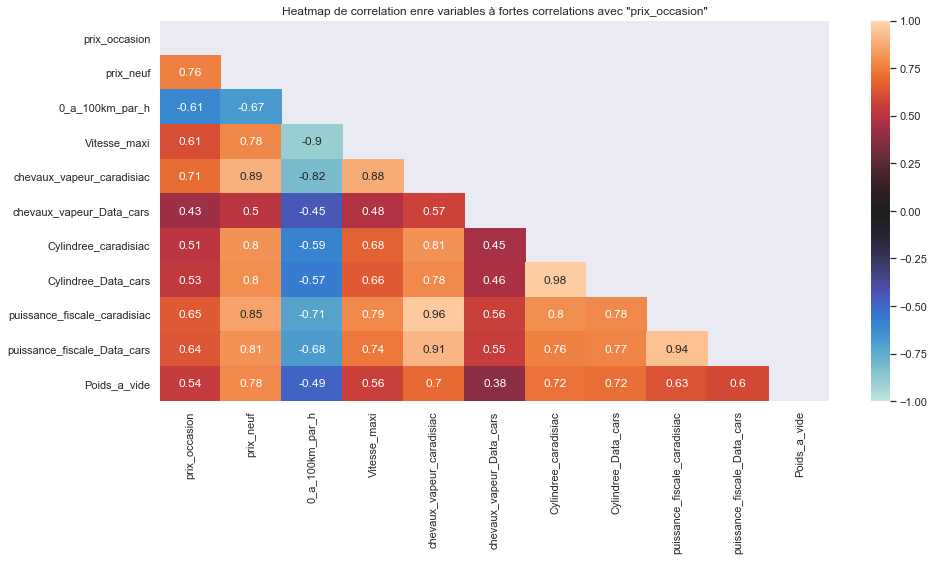

In [552]:
plt.figure(figsize=(15,7))
corr = data_outliers[['prix_occasion', 'prix_neuf', '0_a_100km_par_h', 'Vitesse_maxi',
                      'chevaux_vapeur_caradisiac', 'chevaux_vapeur_Data_cars', 'Cylindree_caradisiac','Cylindree_Data_cars', 
                      'puissance_fiscale_caradisiac', 'puissance_fiscale_Data_cars','Poids_a_vide'
                     ]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.title('Heatmap de correlation enre variables à fortes correlations avec "prix_occasion"')
sns.heatmap(corr, mask=mask, annot = True, vmin=-1, vmax=1, center= 0)


On constate des correlations positives (superieures à 50%) entre prix_occasion est :
 * prix_neuf 
 * Vitesse_maxi
 * chevaux_vapeur_caradisiac : on choisi 'chevaux_vapeur_caradisiac' comme input au modèle car (plus de correlation que 'chevaux_vapeur_Data_cars'),
 * Cylindree_caradisiac et Cylindree_Data_cars : on choisi 'Cylindree_Data_cars' qui a plus de correlation,
 * puissance_fiscale_caradisiac et puissance_fiscale_caradisiac : on choisi puissance_fiscale_caradisiac)
 * Poids_a_vide
    
On constate des correlations négatives (inférieures à -50%) entre prix_occasion est :
 * 0_a_100km_par_h

#### 1.4.2. Variables à faibles correlations avec 'prix_occasion'

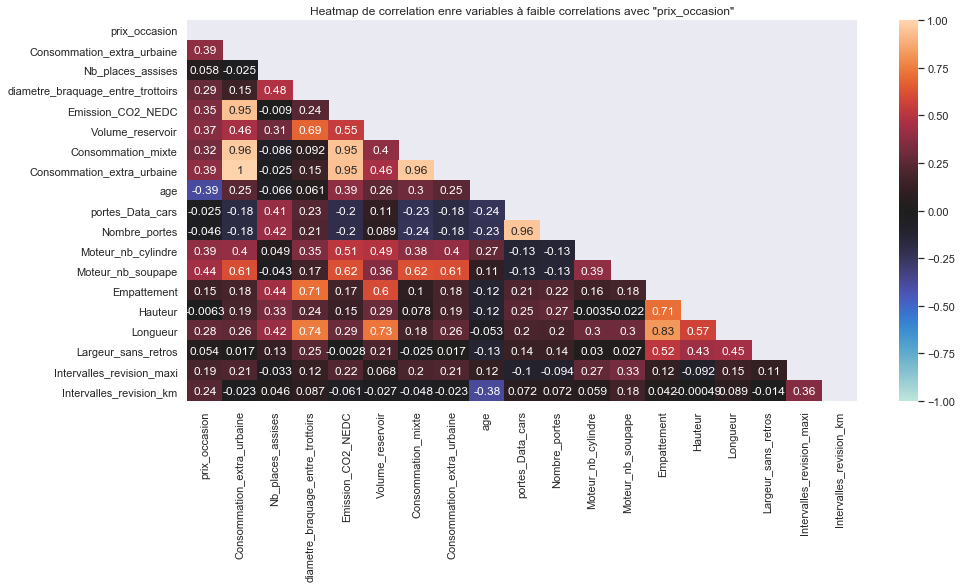

In [551]:
plt.figure(figsize=(15,7))
corr = data_outliers[['prix_occasion', 'Consommation_extra_urbaine',
                      'Nb_places_assises',  'diametre_braquage_entre_trottoirs','Emission_CO2_NEDC',
                      'Volume_reservoir', 'Consommation_mixte', 'Consommation_extra_urbaine', 'age',
                      'portes_Data_cars', 'Nombre_portes', 'Moteur_nb_cylindre', 'Moteur_nb_soupape', 'Empattement', 
                      'Hauteur', 'Longueur','Largeur_sans_retros','Intervalles_revision_maxi','Intervalles_revision_km'
                     ]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.title('Heatmap de correlation enre variables à faible correlations avec "prix_occasion"')
sns.heatmap(corr, mask=mask, annot = True, vmin=-1, vmax=1, center= 0)


On constate des correlations entre 19% et 50% pour :
 * diametre_braquage_entre_trottoirs
 * diametre_braquage_entre_murs
 * Emission_CO2_NEDC
 * Volume_reservoir
 * Consommation_mixte
 * Consommation_extra_urbaine
 * consommation_urbaine
 * Intervalles_revision_maxi
 * age (correlation négative)
    
Il y a peu de correlation entre prix_occasion est (c'est variables ne vont pas être exploitées par le modèle): 
 * Nb_places_assises, 
 * Nombre_portes (portes_Data_cars)
 * Empattement
 * Hauteur
 * Longueur
 * Largeur_sans_retros
 * Intervalles_revision_km
    
    
pas exploitable tel quel: 
    * freins_disque
    * Roue_secours
    * Taille_pneus_arriere
    * Taille_pneus_avant
    * Couple
  

#### 1.4.3. Autres variables (qualitatives)

**Variables qualitatives (Catégorielles) :**
 * blockage_differentiel : oui/non
 * Suspension_arriere : 'NC', 'essieu torsionnel', 'jambe de force', 'multi-bras','essieu rigide', 'bras tirés', 'EU6', 'bras superposés', 'EU6.2 (C and D-Temp)', 'autre'
 * Suspension_avant : 'NC', 'jambe de force', 'multi-bras', 'bras superposés', '--', '0 € de malus', 'essieu rigide'
 * **Roues_motrices** : 'AV', '4x4', 'AR', 'Automatique à 6 rapports', 'Automatique à 8 rapports', nan      
 *  Type_suralimentation : 'turbo', 'Pas de suralimentation', 'turbo avec intercooler', 'turbocharger', 'turbocompresseur', 'NC', '400 Nm', 'turbo avec intercoole', 'compresseur', '350 Nm', 'turbo & compresseur', '375 Nm à 2 330 trs/min', 'Turbocharger', 'both', 'les deux', 'turbo / compresseur', 'supercharger', '590 Nm à 1 250 trs/min', 'turbo et compresseur', 'double turbo', 'turbo électrique et superchargeur', '700 Nm', nan, 'turbo électrique'      
 * Motorisation : 'Diesel', 'Essence', 'Hybride diesel électrique',
       'Hybride rechargeable Essence électrique',
       'Hybride essence électrique', 'Bicarburation essence bioéthanol',
       'Biocarburant essence GPL', 'Electrique', 'Biocarburant',
       'Bicarburation essence GNV'      
 * Autonomie_electrique:  nan, 'AV', '4x4', 'NC', '195 km']

## 2. Modelisation

In [573]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn import metrics

### 2.1. Définition de la metrique MAPE

In [574]:
# Définition de la metrique MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = metrics.make_scorer(mean_absolute_percentage_error, greater_is_better=False)

### 2.2. Définition des transformations de variables

In [16]:
## inspéré de : https://angelosalton.github.io/2019/01/29/predicting-car-prices-with-scikit-learn.html

def preproc_config(categorical_features, numeric_features, num_strat='median'):
    ######
    # Traitement des valeurs manquantes
    # Application de OneHotEncoder sur les variables qualitatives
    # Application de la standardisation sur les variable quantitatives (numériques)
    # Parametters: categorical_features, numeric_features, num_strat
    # return: ColumnTransformer
    ######
    
    # 1. numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=num_strat)),
        ('scaler', StandardScaler())
        ])
    # 2. quantitaitive features
    # run once on full dataset to get all category values
    #temp = ColumnTransformer([('cat', OneHotEncoder(), categorical_features)]).fit(X)
    #cats = temp.named_transformers_['cat'].categories_

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(#categories=cats,
                                 sparse=False, handle_unknown='ignore'))
        ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor

### 2.2. Selection des features

In [684]:
target = 'prix_occasion'

# categorical features
categorical_features = ['Fuel', 'Gearbox', 'Make', 'Model', 'Roues_motrices', 'version'] 

# numerical features
numeric_features = ['prix_neuf', 'Mileage', 'age','0_a_100km_par_h', 'Vitesse_maxi',
                      'chevaux_vapeur_caradisiac','Cylindree_Data_cars', 
                      'puissance_fiscale_caradisiac','Poids_a_vide', ###
                     'Emission_CO2_NEDC',
                     'Volume_reservoir', 'Consommation_mixte', 'Consommation_extra_urbaine',
                    'Moteur_nb_cylindre', 'Moteur_nb_soupape']

In [685]:
X = data_outliers[categorical_features+numeric_features].copy()
y = data_outliers[target].values.copy() # prices$

# generation du train et test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((103040, 21), (25760, 21), (103040,), (25760,))

In [686]:
## Initialisation du ColumnTransformer pour la transformation des données
preprocessor = preproc_config(categorical_features, numeric_features)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['prix_neuf', 'Mileage', 'age',
                                  '0_a_100km_par_h', 'Vitesse_maxi',
                                  'chevaux_vapeur_caradisiac',
                                  'Cylindree_Data_cars',
                                  'puissance_fiscale_caradisiac',
                                  'Poids_a_vide', 'Emission_CO2_NEDC',
                                  'Volume_reservoir', 'Consommation_mixte',
                                  'Consommation_extra_urbaine',
                                  'Moteur_nb_cylindre', 'Moteur_nb_soupape']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Fuel', 'Gearbox', 'Make', 'Model',
                                  'Roues_motrices', 'version'])])

### 2.3. Entrainement du modèle avec differents paramètres

In [665]:
# set the tolerance to a large value to make the example faster
model = ensemble.RandomForestRegressor()
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
    ])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['prix_neuf', 'Mileage',
                                                   'age', '0_a_100km_par_h',
                                                   'Vitesse_maxi',
                                                   'chevaux_vapeur_caradisiac',
                                                   'Cylindree_Data_cars',
                                                   'puissance_fiscale_caradisiac',
                                                   'Poids_a_vide',
                                                   'Emission_CO2_NEDC',
                                                   'Volume_reservoir',
                                                   'Consommation_mixte',
                                                   'Consommation_extra_urbaine',
                                                   'Moteur_nb_cylindre',
                                                   'Moteur_nb_soupape']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Fuel', 'Gearbox', 'Make',
                                                   'Model',
                                                   'Roues_motrices'])])),
                ('model', RandomForestRegressor())])

In [671]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__min_samples_leaf':[1, 2]
}
GS_rfm = GridSearchCV(pipe, param_grid, scoring=MAPE, cv= 5)
GS_rfm

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['prix_neuf',
                                                                          'Mileage',
                                                                          'age',
                                                                          '0_a_100km_par_h',
                                                                          'Vitesse_maxi',
                                                                          'chevaux_vapeur_caradisiac',
                                                                          'Cylindree_Data_cars',
                                                                          'puissance_fiscale_caradisiac',
                                                                          'Poids_a_vide',
                                                                          'E...
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Fuel',
                                                                          'Gearbox',
                                                                          'Make',
                                                                          'Model',
                                                                          'Roues_motrices'])])),
                                       ('model',
                                        RandomForestRegressor(n_estimators=4))]),
             param_grid={'model__min_samples_leaf': [1, 2],
                         'model__n_estimators': [50, 100, 200]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [672]:
GS_rfm.fit(X_train,y_train)
print("Best parameter (CV score=%0.3f):" % GS_rfm.best_score_)
print(GS_rfm.best_params_)

Best parameter (CV score=-6.932):
{'model__min_samples_leaf': 2, 'model__n_estimators': 200}


Les meilleurs paramèttres pour le modèle sont :  **n_estimators=200** et **min_samples_leaf=2**

### 2.4. Entrainement du modèle avec les meilleurs paramètres

In [675]:
models_names = ['Forest']

mape = []
scores = []

model = ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=2)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
    ])

fits = pipe.fit(X_train,y_train)

### 2.5. Réalisation de la prédiction sur le test dataset

In [ ]:
mape.append(mean_absolute_percentage_error(y_test, fits.predict(X_test)))
scores.append(metrics.r2_score(y_test, fits.predict(X_test)))

In [678]:
resultat = pd.DataFrame(data=list(zip(models_names, mape, scores)), columns=['model', 'mape', 'scores'])
resultat

,model,mape,scores
0,Forest,6.853996,0.96024


**La MAPE finale = 6,85%**

In [ ]:
models_names = ['Forest']

mape = []
scores = []

model2 = ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=2)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
    ])

fits = pipe.fit(X_train,y_train)

## 3. Sauvegarde du modèle

In [679]:
import pickle
with open('../prediction_prix_occasion_pipe.pickle', 'wb') as f:
    pickle.dump(pipe, f)
with open('../prediction_prix_occasion_model.pickle', 'wb') as f:
    pickle.dump(model, f)

## 4. Conclusion
* Les meilleurs paramèttres pour le modèle sont :  **n_estimators=200** et **min_samples_leaf=2**
* **La MAPE finale sur le test dataset est de 6,85%.**


## 5. Perspectives
Comme perspectives, on exploitera les variables suivantes:
 * Date_fin_commercialisation, 
 * Date_commercialisation,
 * time
 * equips_all  
 * Volume_coffre_mini/maxi
 * options_caradisiac vs. options_DataCars: : ajouter des poids aux options suivant leur prix. 